### DWT-MRA(2D)를 input으로 넣고 2D를 output으로 출력하는 모델
#### Contaminated, Clean Scale을 같게 함.

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import pywt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
fpath = "../../data/DNN_data/v2/"

sig_with_artifact = np.load(fpath + "data_with_non_sine_v2_varying" + ".npy")
sig = np.load(fpath + "data_signal" + ".npy")
artifact = sig_with_artifact - sig

print(sig_with_artifact.shape)
print(sig.shape)

(1000, 4000)
(1000, 4000)


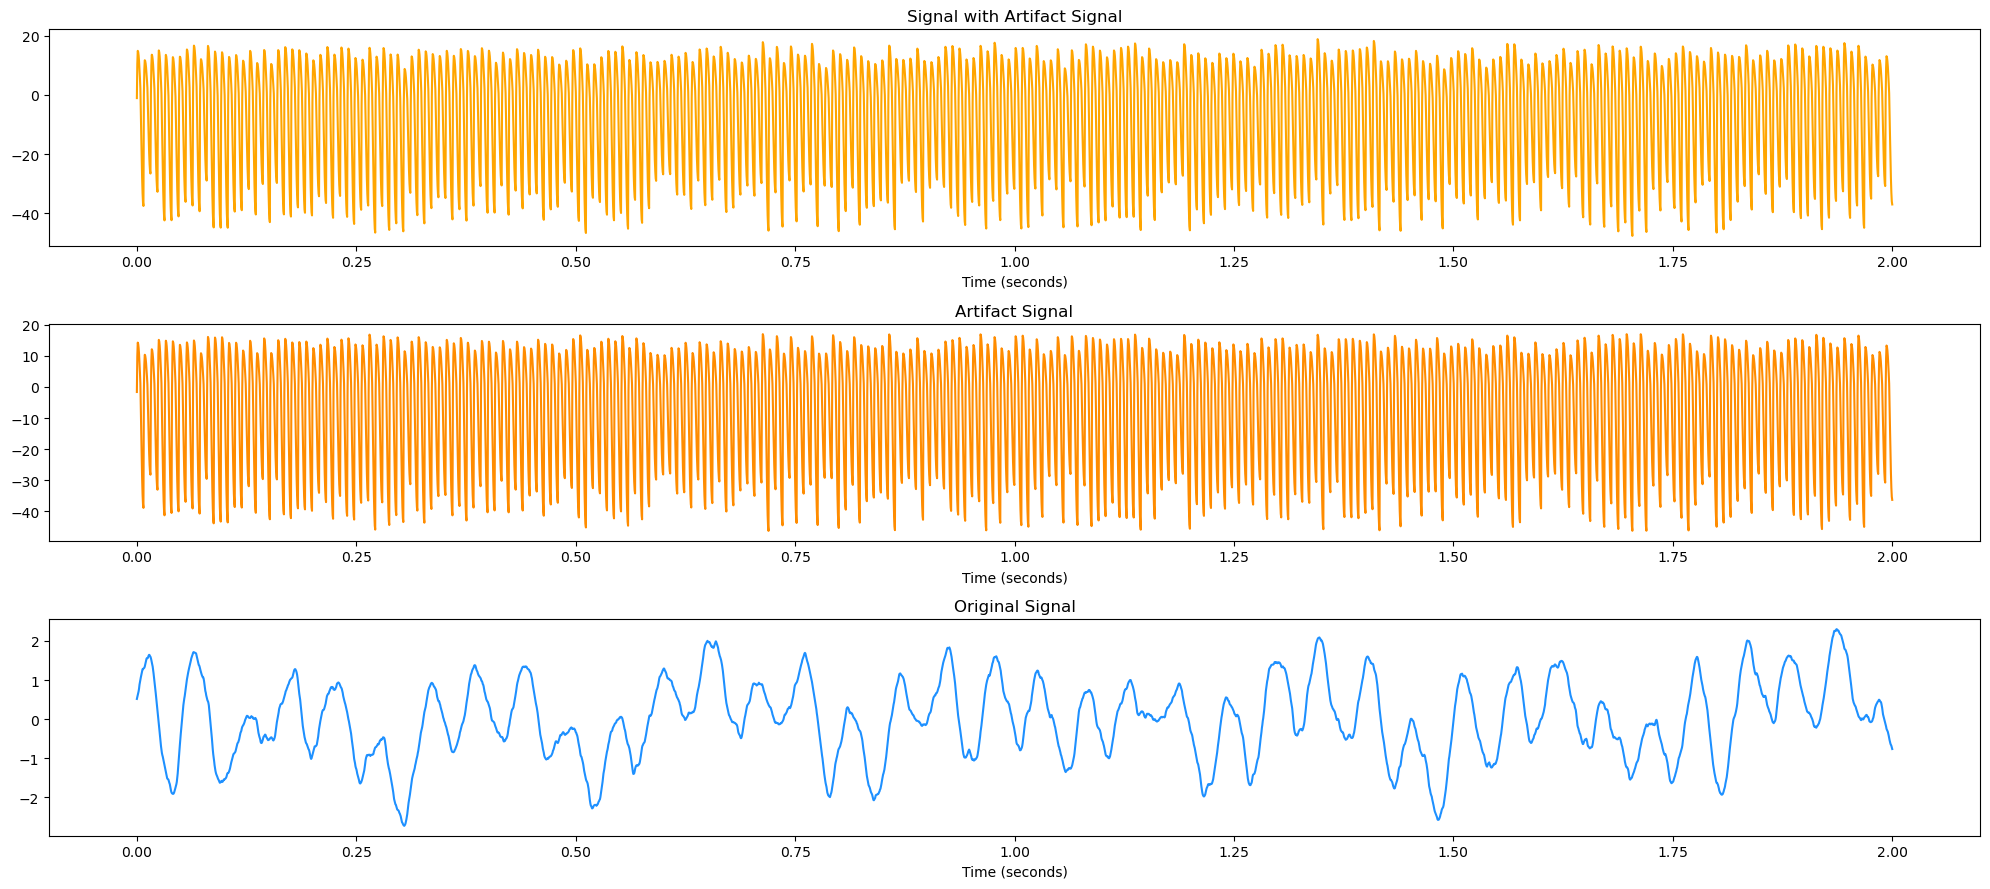

In [3]:
t = np.linspace(0, 2, num=4000) 

plt.figure(figsize=(20,9))
plt.subplot(3, 1, 1)
plt.plot(t, sig_with_artifact[0], color='orange')
plt.xlabel("Time (seconds)")
plt.title('Signal with Artifact Signal')

plt.subplot(3, 1, 2)
plt.plot(t, artifact[0], color='darkorange')
plt.xlabel("Time (seconds)")
plt.title('Artifact Signal')

plt.subplot(3, 1, 3)
plt.plot(t, sig[0], color='dodgerblue')
plt.xlabel("Time (seconds)")
plt.title('Original Signal')

plt.tight_layout()

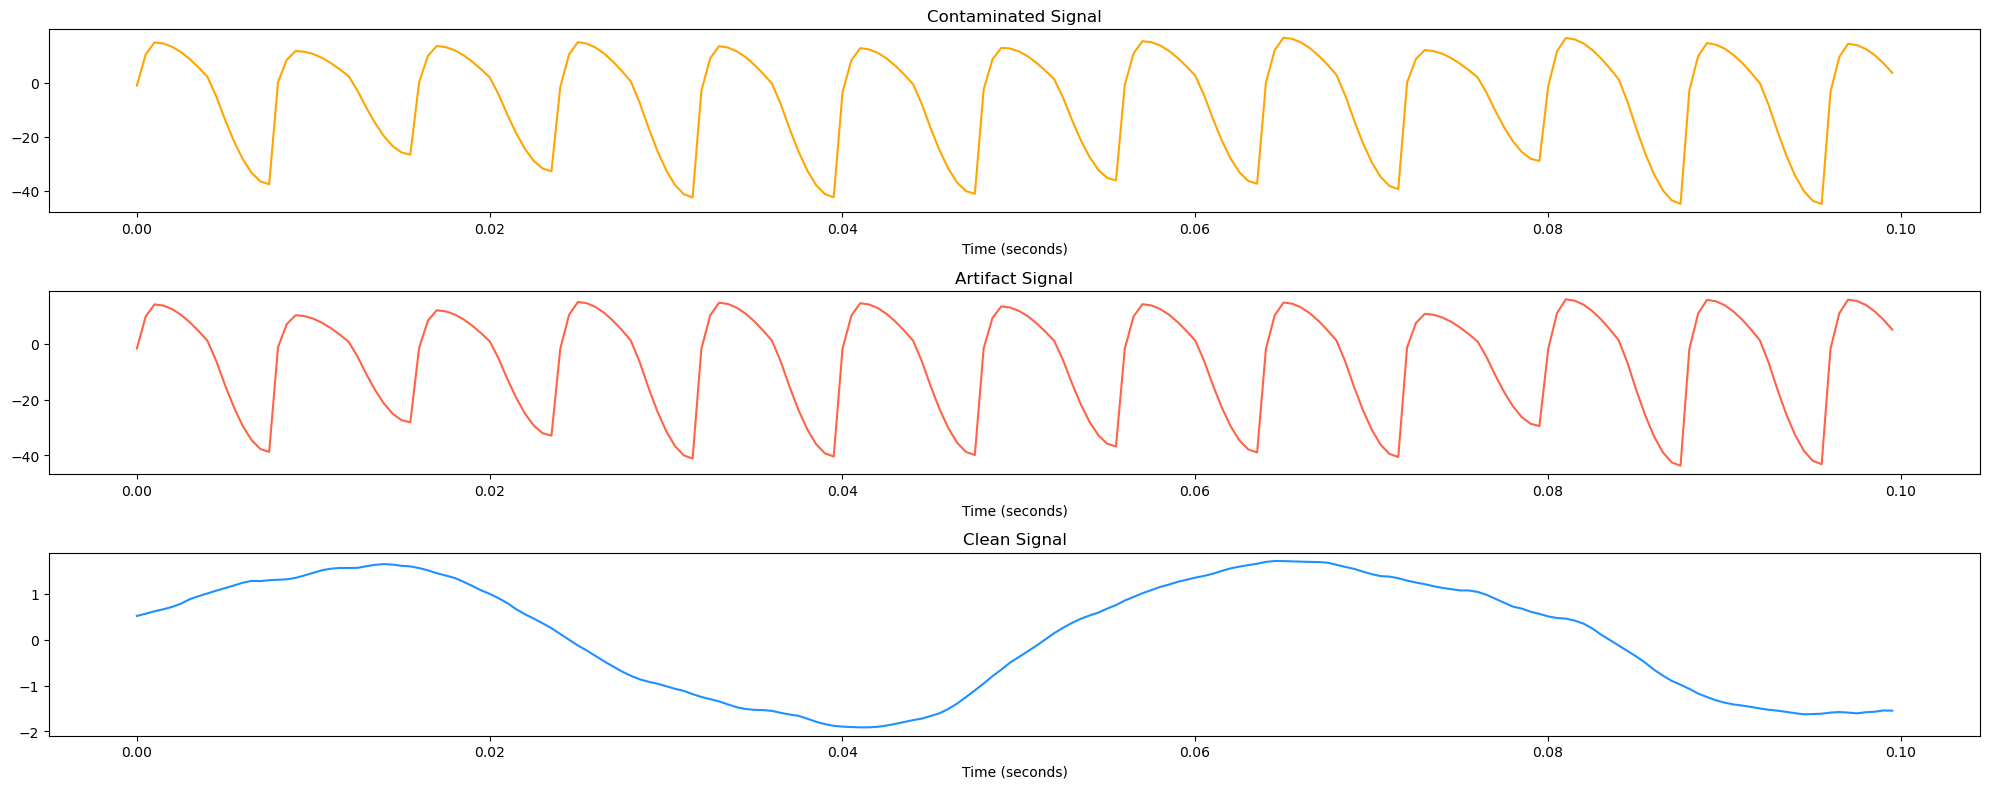

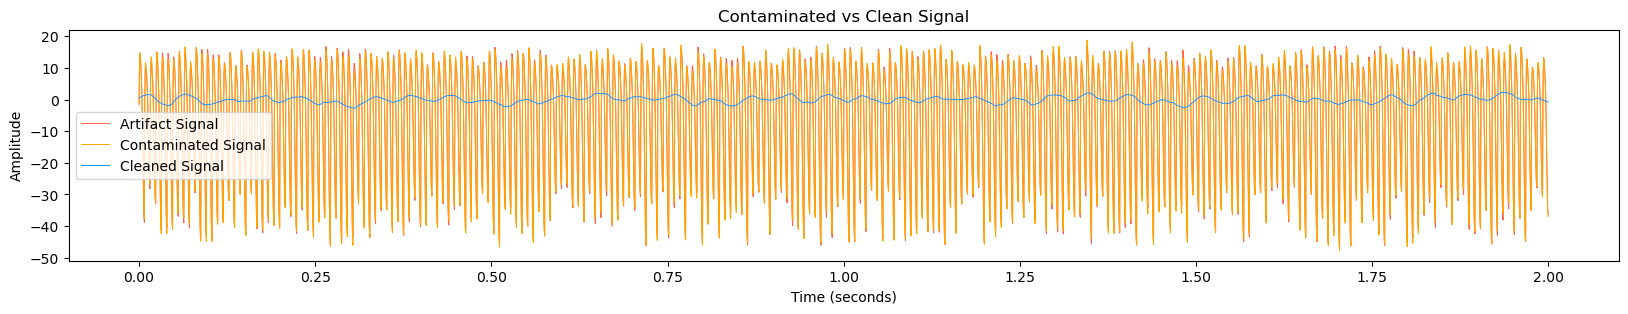

In [4]:
t = np.linspace(0, 2, num=4000) 

plt.figure(figsize=(20,8))
plt.subplot(3, 1, 1)
plt.plot(t[:200], sig_with_artifact[0][:200], color='orange')
plt.xlabel("Time (seconds)")
plt.title('Contaminated Signal')

plt.subplot(3, 1, 2)
plt.plot(t[:200], artifact[0][:200], color='tomato')
plt.xlabel("Time (seconds)")
plt.title('Artifact Signal')

plt.subplot(3, 1, 3)
plt.plot(t[:200], sig[0][:200], color='dodgerblue')
plt.xlabel("Time (seconds)")
plt.title('Clean Signal')

plt.tight_layout()

plt.figure(figsize=(20, 3))
plt.plot(t, artifact[0], label='Artifact Signal', color='tomato', alpha=1, linewidth=0.7)
plt.plot(t, sig_with_artifact[0], label='Contaminated Signal', color='orange', alpha=1, linewidth=0.7)
plt.plot(t, sig[0], label='Cleaned Signal', color='dodgerblue', alpha=1, linewidth=0.7)
plt.xlabel('Time (seconds)');plt.ylabel('Amplitude');plt.title('Contaminated vs Clean Signal');plt.legend();plt.show()

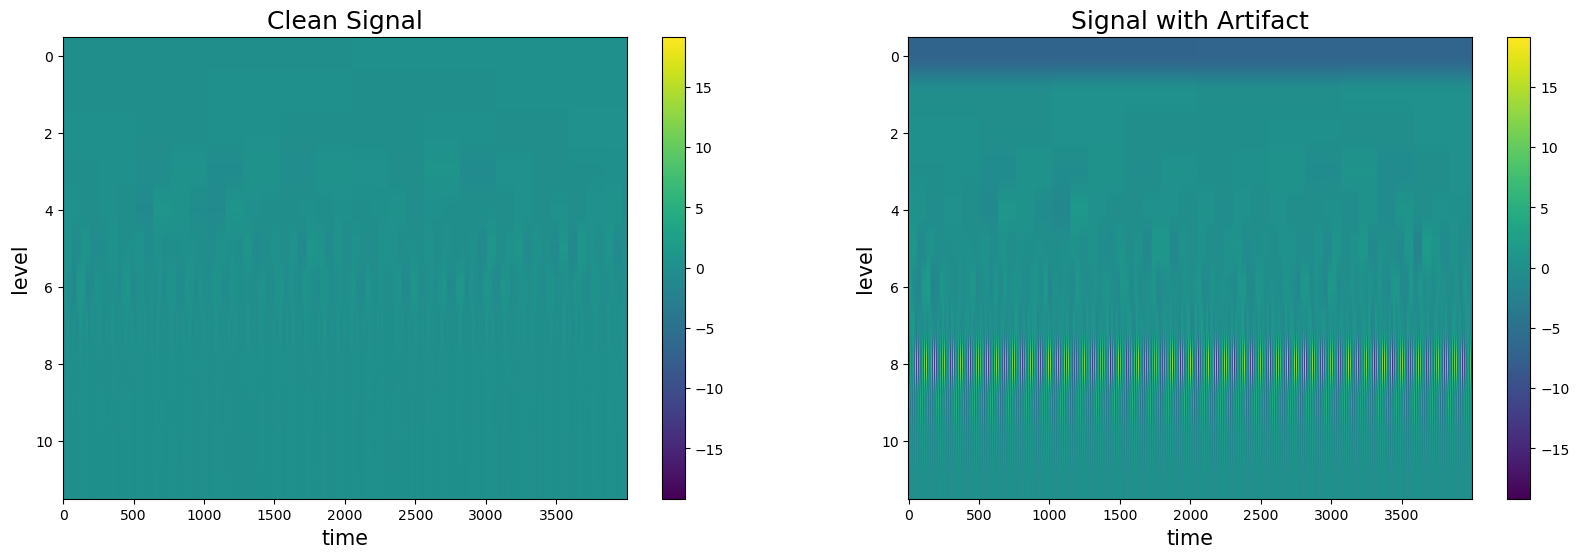

In [5]:
# DWT 수행 (MRA)
wavelet = 'db1'
mra_sig = pywt.mra(sig[0], wavelet, transform='dwt')
mra_art = pywt.mra(sig_with_artifact[0], wavelet, transform='dwt')

mra_sig = np.array(mra_sig)
mra_art = np.array(mra_art)

vmin, vmax = min(mra_sig.min(), mra_art.min()), max(mra_sig.max(), mra_art.max())

plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.imshow(mra_sig, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.xlabel('time', fontsize=15)
plt.ylabel('level', fontsize=15)
plt.title('Clean Signal', fontsize=18)

plt.subplot(1, 2, 2)
plt.imshow(mra_art, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.xlabel('time', fontsize=15)
plt.ylabel('level', fontsize=15)
plt.title('Signal with Artifact', fontsize=18)

plt.show()

In [6]:
X_wt = []
y_wt = []

wavelet = 'db1'

for x, y in zip(sig_with_artifact, sig):
    mra_x = pywt.mra(x, wavelet, transform='dwt')
    mra_y = pywt.mra(y, wavelet, transform='dwt')
    X_wt.append(mra_x)
    y_wt.append(mra_y)

X_wt = np.array(X_wt)
y_wt = np.array(y_wt)

print("X_wt:", X_wt.shape)
print("y_wt:", y_wt.shape)

X_wt: (1000, 12, 4000)
y_wt: (1000, 12, 4000)


In [7]:
# MRA 결과 scaling
scaler_x = StandardScaler()

X = []
y = [] 

for xx, yy in zip(X_wt, y_wt):
    flat_x = xx.flatten().reshape(-1, 1)
    flat_y = yy.flatten().reshape(-1, 1)
    scaled_flat_x = scaler_x.fit_transform(flat_x)
    scaled_flat_y = (flat_y-scaler_x.mean_)/np.sqrt(scaler_x.var_) # X와 동일한 평균, 표준 편차로 scaling
    X.append(scaled_flat_x.reshape(xx.shape))
    y.append(scaled_flat_y.reshape(yy.shape))

X = np.array(X)
y = np.array(y)

print("X:", X.shape)
print("y:", y.shape)

X: (1000, 12, 4000)
y: (1000, 12, 4000)


In [8]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("<Original>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x T, y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

# 차원 추가 (CNN은 두번째 차원 추가)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2]) # B x 1 x T
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])

print("<Unsqueezed>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x 1 x T, y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

<Original>
-----------------------------
X_train shape: (800, 12, 4000)
y_train shape: (800, 12, 4000)
-----------------------------
X_test shape: (200, 12, 4000)
y_test shape: (200, 12, 4000)
-----------------------------
<Unsqueezed>
-----------------------------
X_train shape: (800, 1, 12, 4000)
y_train shape: (800, 12, 4000)
-----------------------------
X_test shape: (200, 1, 12, 4000)
y_test shape: (200, 12, 4000)
-----------------------------


In [9]:
class CNN2D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(CNN2D, self).__init__()
        
        # Encoding path
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        # Decoding path
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.upconv1 = nn.Conv2d(64, out_channels, kernel_size=1)

        self.gelu = nn.GELU()
        
    def forward(self, x):
        # Encoding
        x1 = self.gelu(self.conv1(x))
        x2 = self.pool(self.gelu(self.conv2(x1)))
        x3 = self.pool(self.gelu(self.conv3(x2)))
        
        # Decoding
        x3_up = self.upconv3(x3)
        x2_up = self.upconv2(x3_up)
        x_out = self.upconv1(x2_up)
        
        return x_out

In [10]:
num_samples = 4000
height = 12
width = 2000

model = CNN2D().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
# 모델 학습
num_epochs = 200

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        y = y.reshape(y.shape[0], 1, y.shape[1], y.shape[2])
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    if (epoch+1)%1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}')

Epoch [1/200], Loss: 0.0033
Epoch [2/200], Loss: 0.0025
Epoch [3/200], Loss: 0.0019
Epoch [4/200], Loss: 0.0014
Epoch [5/200], Loss: 0.0011
Epoch [6/200], Loss: 0.0010
Epoch [7/200], Loss: 0.0010
Epoch [8/200], Loss: 0.0010
Epoch [9/200], Loss: 0.0009
Epoch [10/200], Loss: 0.0010
Epoch [11/200], Loss: 0.0009
Epoch [12/200], Loss: 0.0009
Epoch [13/200], Loss: 0.0009
Epoch [14/200], Loss: 0.0009
Epoch [15/200], Loss: 0.0009
Epoch [16/200], Loss: 0.0009
Epoch [17/200], Loss: 0.0009
Epoch [18/200], Loss: 0.0008
Epoch [19/200], Loss: 0.0008
Epoch [20/200], Loss: 0.0008
Epoch [21/200], Loss: 0.0009
Epoch [22/200], Loss: 0.0008
Epoch [23/200], Loss: 0.0008
Epoch [24/200], Loss: 0.0008
Epoch [25/200], Loss: 0.0008
Epoch [26/200], Loss: 0.0008
Epoch [27/200], Loss: 0.0008
Epoch [28/200], Loss: 0.0008
Epoch [29/200], Loss: 0.0008
Epoch [30/200], Loss: 0.0008
Epoch [31/200], Loss: 0.0008
Epoch [32/200], Loss: 0.0008
Epoch [33/200], Loss: 0.0008
Epoch [34/200], Loss: 0.0008
Epoch [35/200], Loss: 0

In [25]:
# 모델 평가
Contaminated = torch.tensor([])
Clean = torch.tensor([])
SACed = torch.tensor([])

model.eval()
test_loss = 0.0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y = y.reshape(y.shape[0], 1, y.shape[1], y.shape[2])
        
        y_pred = model(x)
        loss = criterion(y_pred, y)
        test_loss += loss.item() * x.size(0)

        Contaminated = torch.cat((Contaminated, x.squeeze().cpu()), 0)
        SACed = torch.cat((SACed, y_pred.squeeze().cpu()), 0)
        Clean = torch.cat((Clean, y.squeeze().cpu()), 0)

test_loss /= len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.0006


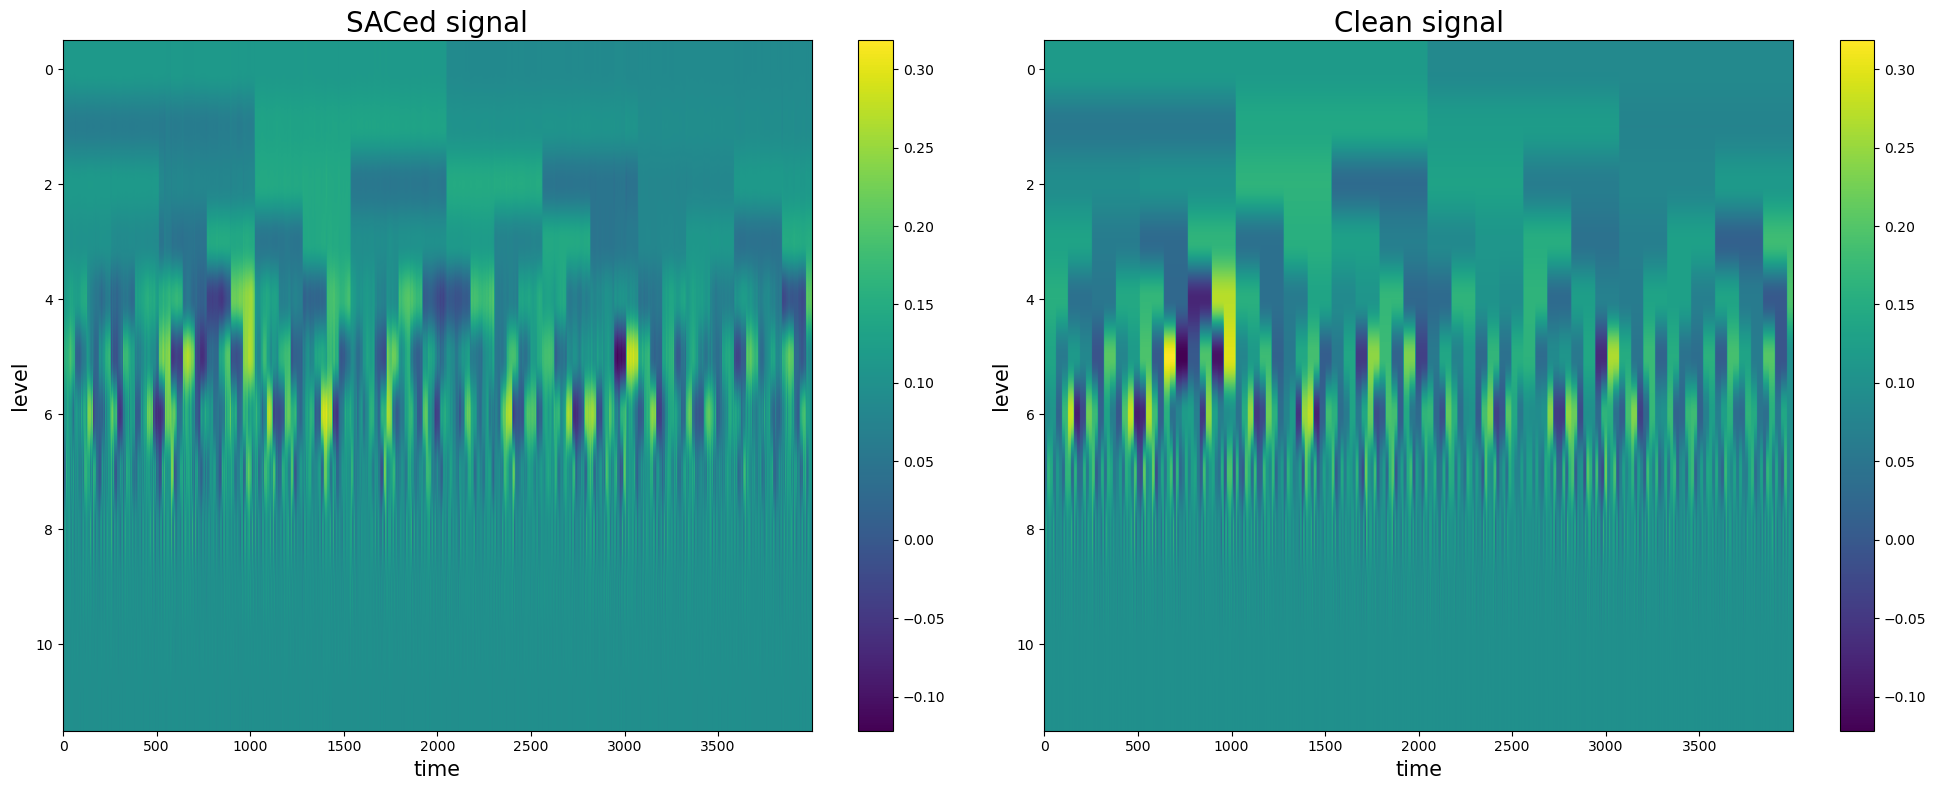

In [26]:
SACed_ex = SACed[0].detach().cpu()
Clean_ex = Clean[0].detach().cpu()

vmin, vmax = min(SACed_ex.min(), Clean_ex.min()), max(SACed_ex.max(), Clean_ex.max())

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(SACed_ex, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.xlabel('time', fontsize=15)
plt.ylabel('level', fontsize=15)
plt.title('SACed signal', fontsize=20)

plt.subplot(1, 2, 2)
plt.imshow(Clean_ex, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.xlabel('time', fontsize=15)
plt.ylabel('level', fontsize=15)
plt.title('Clean signal', fontsize=20)

plt.tight_layout()
plt.show()

Mean Absolute Error: 0.01433202251791954
Mean Squared Error: 0.00032816469320096076


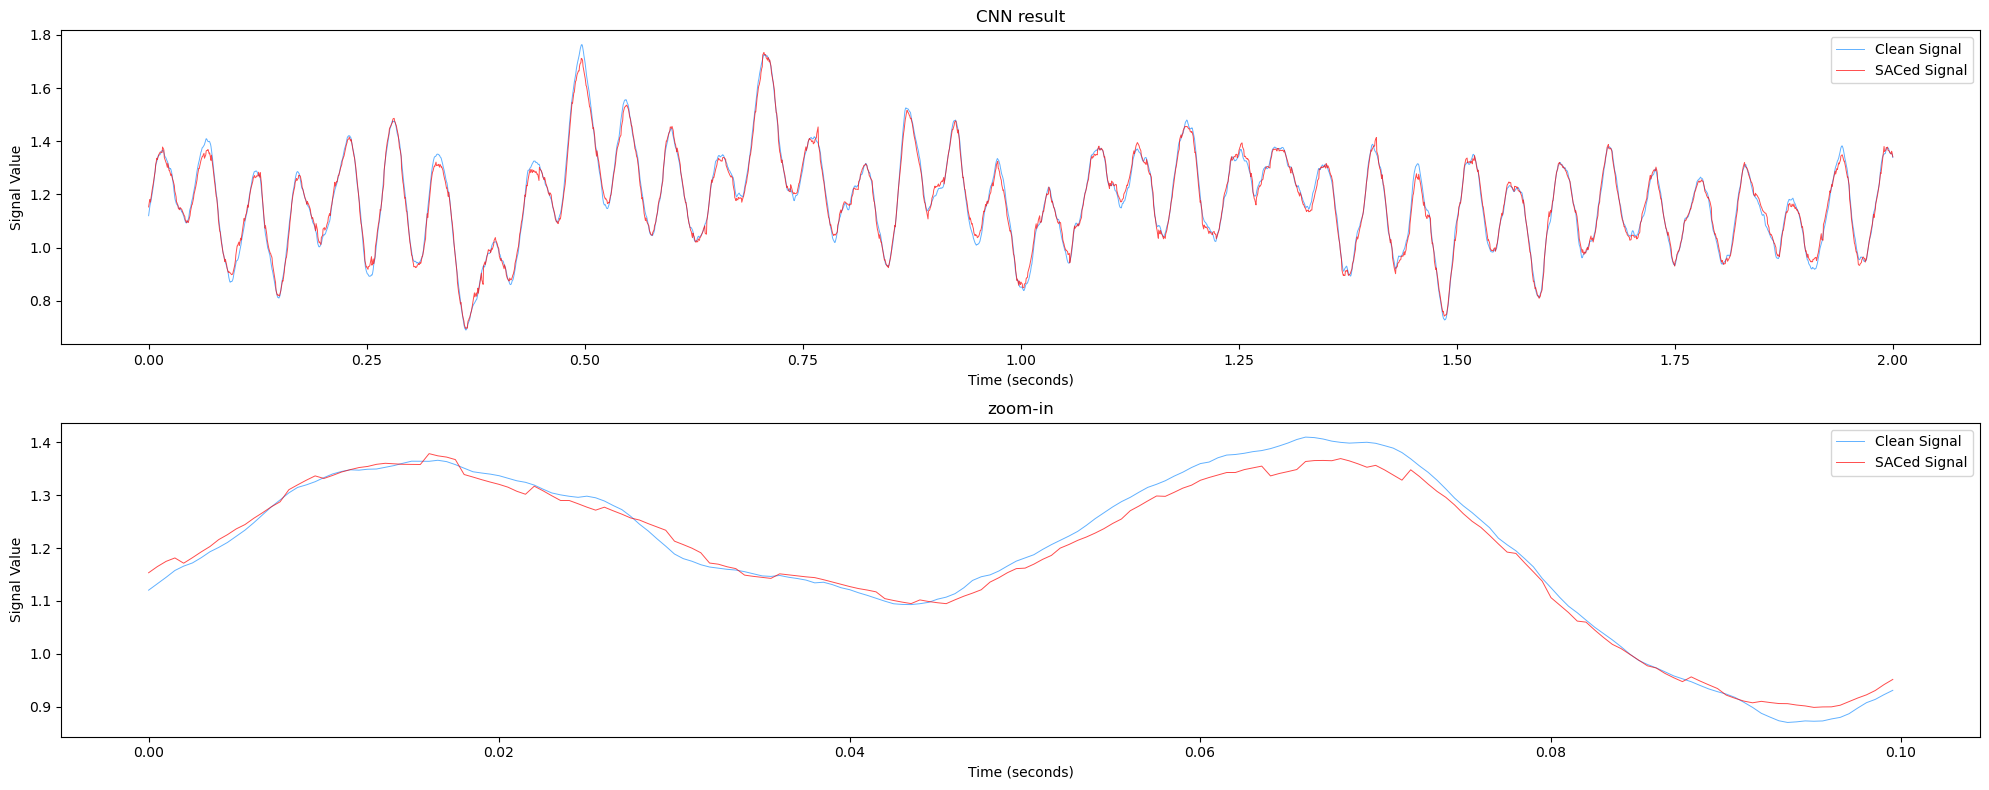

In [31]:
# time domain plotting

Contaminated_signal = pywt.imra(Contaminated[0])
SACed_signal = pywt.imra(SACed[0])
Clean_signal = pywt.imra(Clean[0])

plt.figure(figsize=(20,8))
plt.subplot(2, 1, 1)
# plt.plot(t, Contaminated_signal, label='Contaminated Signal', color='orange', alpha=0.7, linewidth=0.7)
plt.plot(t, Clean_signal, label='Clean Signal', color='dodgerblue', alpha=0.7, linewidth=0.7)
plt.plot(t, SACed_signal, label='SACed Signal', color='red', alpha=0.7, linewidth=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.title('CNN result')
plt.legend()



plt.subplot(2, 1, 2)
# plt.plot(t[:200], Contaminated_signal[:200], label='Contaminated Signal', color='orange', alpha=0.7, linewidth=0.7)
plt.plot(t[:200], Clean_signal[:200], label='Clean Signal', color='dodgerblue', alpha=0.7, linewidth=0.7)
plt.plot(t[:200], SACed_signal[:200], label='SACed Signal', color='red', alpha=0.7, linewidth=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.title('zoom-in')
plt.legend()

plt.tight_layout()

print(f"Mean Absolute Error: {mean_absolute_error(Clean_signal, SACed_signal)}")
print(f"Mean Squared Error: {mean_squared_error(Clean_signal, SACed_signal)}")

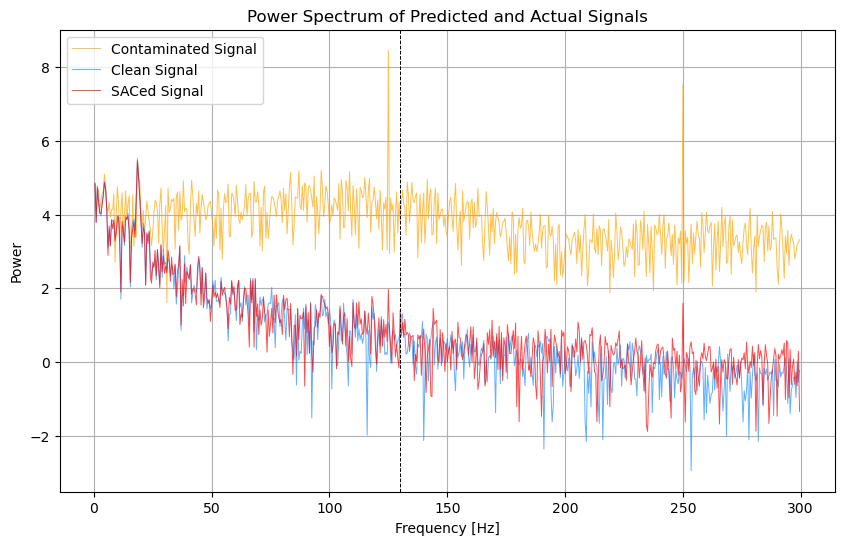

Mean Absolute Error: 0.5718719363212585
Mean Squared Error: 0.5431503057479858


In [29]:
# frequency domain plotting

n = len(SACed_signal)

fs = 2000
freqs = np.fft.fftfreq(n, d=1/fs)[:n//2]

fft_predicted = np.fft.fft(SACed_signal)
fft_predicted = np.abs(fft_predicted[:n//2])
fft_predicted[1:] = 2 * fft_predicted[1:]
power_predicted = fft_predicted**2

fft_actual = np.fft.fft(Clean_signal)
fft_actual = np.abs(fft_actual[:n//2])
fft_actual[1:] = 2 * fft_actual[1:]
power_actual = fft_actual**2

fft_nonSACed = np.fft.fft(Contaminated_signal)
fft_nonSACed = np.abs(fft_nonSACed[:n//2])
fft_nonSACed[1:] = 2 * fft_nonSACed[1:]
power_nonSACed = fft_nonSACed**2

# 결과 플로팅
plt.figure(figsize=(10, 6))
plt.plot(freqs[1:600], np.log10(power_nonSACed)[1:600], label='Contaminated Signal', color='orange', alpha=0.7, linewidth=0.7)
plt.plot(freqs[1:600], np.log10(power_actual)[1:600], label='Clean Signal', color='dodgerblue', alpha=0.7, linewidth=0.7)
plt.plot(freqs[1:600], np.log10(power_predicted)[1:600], label='SACed Signal', color='red', alpha=0.7, linewidth=0.7)
plt.title('Power Spectrum of Predicted and Actual Signals')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.axvline(x=130, color='black', linestyle='--',label='130 Hz', linewidth=0.7)
plt.show()

print(f"Mean Absolute Error: {mean_absolute_error(np.log10(power_predicted), np.log10(power_actual))}")
print(f"Mean Squared Error: {mean_squared_error(np.log10(power_predicted), np.log10(power_actual))}")